In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2023-06-20 02:30:59.596292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# RNN on the Trip Advisor dataset

# Preprocessing

In [2]:
df = pd.read_csv('/Users/admin-20218/Desktop/EPITA/Semester3/Deep Learning/Exam/Trip_advisor_reviews - Trip_advisor_reviews.csv')
df.head()

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


**<font color='blue'>Create the TextVectorization layer with `max_tokens=5000`, `output_mode='int'` and `output_sequence_length=200`.<br>Use `.adapt()` method of the TextVectorization layer to get the vocabulary of the dataset.**

In [3]:
vect = tf.keras.layers.TextVectorization(max_tokens=5000,
                                         output_mode='int',
                                         output_sequence_length=200)
df['review_full'] = df['review_full'].fillna('')
df['review_full'] = df['review_full'].astype(str)
vect.adapt(df['review_full'].to_numpy().flatten())

In [4]:
# The [UNK] token is a special token used in natural language processing
# that represents an unknown or out-of-vocabulary (OOV) word.

print(f"There are : {len(vect.get_vocabulary())} words in the vocabulary")
print(f"The first 10 words are : {vect.get_vocabulary()[:10]}")
print(f"The last 10 words are : {vect.get_vocabulary()[-10:]}")

There are : 5000 words in the vocabulary
The first 10 words are : ['', '[UNK]', 'the', 'and', 'a', 'to', 'is', 'of', 'was', 'in']
The last 10 words are : ['drumsticks', 'creations', 'cajun', 'artificial', 'ale', 'aesthetic', 'additionally', 'wet', 'travels', 'subs']


**<font color='blue'>Transform the text into tokens.<br>Separate the reviews from the label.<br>Split the data into a training, a validation and a testing sets.**

In [5]:
X = vect(df['review_full'].to_numpy()).numpy()
y = df['rating_review']

In [6]:
X[0]

array([ 465,    9,  110,   13,    2,    1,    7,    2,   18,   57,  243,
          3,  105, 1130,   32,    2,  224,   52,    2,   70,    6,   20,
        909,    3,  622,    4, 1510,    7,    1, 1537,  655,    3, 1168,
        743,   22,  105, 2212,    3, 1396,  110,    2,  406,  466, 1114,
          3,   40,  427,    1,    1,  700,    5,    1,   31, 2450,  723,
          1, 1413,    5,  371,    2,    1,    9,  518,  726,   37,    2,
          1,    1,   44,    2, 2289,    7,    2,   18,   13,    2,    1,
         24,   45,   48,    3, 1542,   16,    1,    2,   11,    6,   57,
         74,  360,    2,  140, 1667,   44,    2, 1609,    3,    2, 1432,
          3, 1522,  333,   22,  105,   82,   69,   55,  710,  277,   12,
          4, 1003,  490,  998,  335,   18,    9,    1,    6,    4,   81,
          5,   12,   19,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2/(1-0.2), stratify=y_train, random_state=42)

### Simple RNN.

**<font color='blue'>Create a neural network with a simple RNN layer and compile it.<br>Train it and display the learning curves.**

In [39]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

In [40]:
reset_seeds()
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(1, input_shape = (200,1))])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [41]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)

history = model.fit(X_train[...,np.newaxis], y_train,
                         epochs=10,
                         batch_size=128,
                         validation_data=(X_val[...,np.newaxis], y_val),
                         callbacks=[early])

Epoch 1/10
692/692 [==============================] - 28s 35ms/step - loss: 0.6763 - accuracy: 0.0036 - val_loss: -0.9728 - val_accuracy: 0.0047
Epoch 2/10
692/692 [==============================] - 27s 38ms/step - loss: -1.7579 - accuracy: 0.0234 - val_loss: -2.5112 - val_accuracy: 0.0302
Epoch 3/10
692/692 [==============================] - 33s 47ms/step - loss: -3.0562 - accuracy: 0.0302 - val_loss: -3.6401 - val_accuracy: 0.0302
Epoch 4/10
692/692 [==============================] - 31s 44ms/step - loss: -4.0956 - accuracy: 0.0302 - val_loss: -4.6076 - val_accuracy: 0.0302
Epoch 5/10
692/692 [==============================] - 24s 34ms/step - loss: -5.0220 - accuracy: 0.0302 - val_loss: -5.5002 - val_accuracy: 0.0302
Epoch 6/10
692/692 [==============================] - 23s 33ms/step - loss: -5.8946 - accuracy: 0.0302 - val_loss: -6.3563 - val_accuracy: 0.0302
Epoch 7/10
692/692 [==============================] - 23s 33ms/step - loss: -6.7426 - accuracy: 0.0302 - val_loss: -7.1976 - 

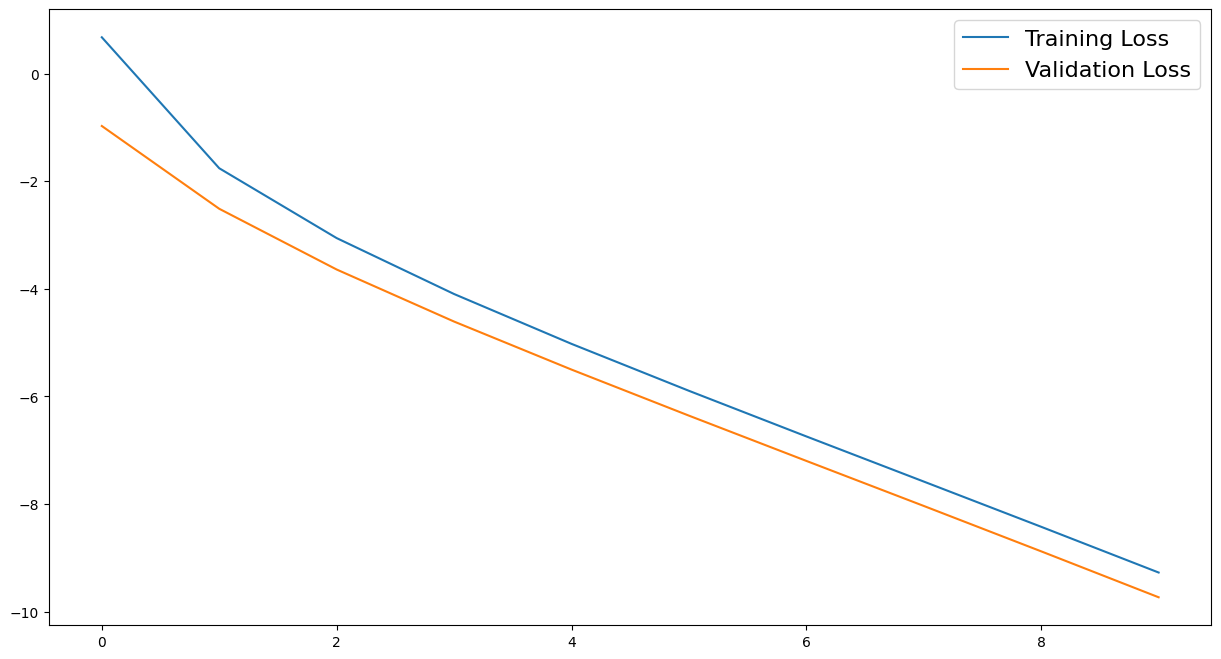

In [42]:
# Learning Curves
plt.figure(figsize=(15,8))

epochs_run = len(history.history['loss'])
plt.plot(np.arange(0, epochs_run), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, epochs_run), history.history['val_loss'], label='Validation Loss')


plt.legend(fontsize=16)
plt.show()

In [43]:
#prediction 
y_pred = model.predict(X_test)

923/923 [==============================] - 11s 12ms/step


In [44]:
y_pred=np.argmax(y_pred, axis=-1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
from sklearn.metrics import mean_squared_error
print(f"Single RNN MSE: {mean_squared_error(y_pred, y_test):.4f}")

Single RNN MSE: 18.8355


# Deep RNN.

**<font color='blue'>Create a neural network with multiple RNN layers that contains multiple recurrent neurons and compile it.<br> Train it and display the learning curves.**

In [15]:
reset_seeds()
tf.keras.backend.clear_session()

model_10_drnn = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(200, 1)),
                                            tf.keras.layers.SimpleRNN(20),
                                            tf.keras.layers.Dense(10)])

model_10_drnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                      loss=tf.keras.losses.MeanSquaredError())

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model_10_drnn.fit(X_train, y_train,
                            epochs=10,
                            batch_size=256,
                            validation_data=(X_val, y_val),
                            callbacks=[early])

Epoch 1/10
346/346 [==============================] - 28s 75ms/step - loss: 1.7286 - val_loss: 0.9357
Epoch 2/10
346/346 [==============================] - 26s 76ms/step - loss: 0.9376 - val_loss: 0.9350
Epoch 3/10
346/346 [==============================] - 25s 72ms/step - loss: 0.9452 - val_loss: 1.0240
Epoch 4/10
346/346 [==============================] - 25s 73ms/step - loss: 1.1142 - val_loss: 0.9381
Epoch 5/10
346/346 [==============================] - 25s 72ms/step - loss: 0.9387 - val_loss: 0.9372
Epoch 6/10
346/346 [==============================] - 25s 73ms/step - loss: 0.9376 - val_loss: 0.9365
Epoch 7/10
346/346 [==============================] - 25s 71ms/step - loss: 0.9384 - val_loss: 0.9385


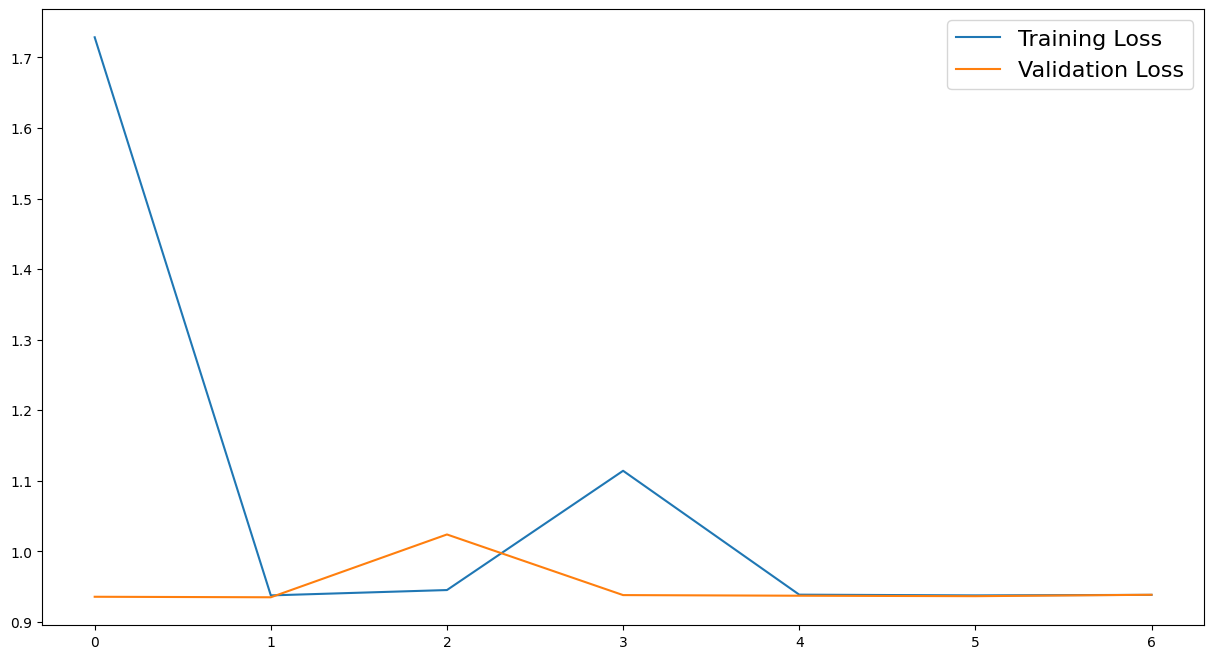

In [16]:
# Learning Curves
plt.figure(figsize=(15,8))

epochs_run = len(history.history['loss'])
plt.plot(np.arange(0, epochs_run), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, epochs_run), history.history['val_loss'], label='Validation Loss')


plt.legend(fontsize=16)
plt.show()

In [34]:
y_pred = model_10_drnn.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)

923/923 [==============================] - 18s 20ms/step


In [35]:
y_pred

array([6, 6, 6, ..., 6, 6, 6])

In [36]:
from sklearn.metrics import mean_squared_error
print(f"Deep RNN with 10 steps forward MSE : {mean_squared_error(np.ravel(y_pred), np.ravel(y_test)):.4f}")

Deep RNN with 10 steps forward MSE : 4.4940


In [37]:
model_10_drnn.evaluate(X_test, y_test)

923/923 [==============================] - 23s 25ms/step - loss: 0.9362


0.9362083077430725

#  Bidirectional Deep RNN

In [47]:
reset_seeds()
tf.keras.backend.clear_session()

model_10_birnn = tf.keras.models.Sequential([tf.keras.Input(shape=(200, 1)),
                                             tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20, return_sequences=True)),
                                             tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20)),
                                             tf.keras.layers.Dense(10)])

model_10_birnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                       loss=tf.keras.losses.MeanSquaredError())

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model_10_birnn.fit(X_train, y_train,
                             epochs=10,
                             batch_size=256,
                             validation_data=(X_val, y_val),
                             callbacks=[early])

Epoch 1/10
346/346 [==============================] - 90s 241ms/step - loss: 1.2958 - val_loss: 0.9371
Epoch 2/10
346/346 [==============================] - 120s 347ms/step - loss: 0.9388 - val_loss: 0.9363
Epoch 3/10
346/346 [==============================] - 75s 216ms/step - loss: 0.9378 - val_loss: 0.9360
Epoch 4/10
346/346 [==============================] - 70s 203ms/step - loss: 0.9380 - val_loss: 0.9358
Epoch 5/10
346/346 [==============================] - 71s 205ms/step - loss: 0.9379 - val_loss: 0.9349
Epoch 6/10
346/346 [==============================] - 99s 287ms/step - loss: 0.9387 - val_loss: 0.9404
Epoch 7/10
346/346 [==============================] - 73s 212ms/step - loss: 0.9407 - val_loss: 0.9371
Epoch 8/10
346/346 [==============================] - 77s 224ms/step - loss: 0.9391 - val_loss: 0.9359
Epoch 9/10
346/346 [==============================] - 75s 217ms/step - loss: 0.9399 - val_loss: 0.9407
Epoch 10/10
346/346 [==============================] - 83s 240ms/step - 

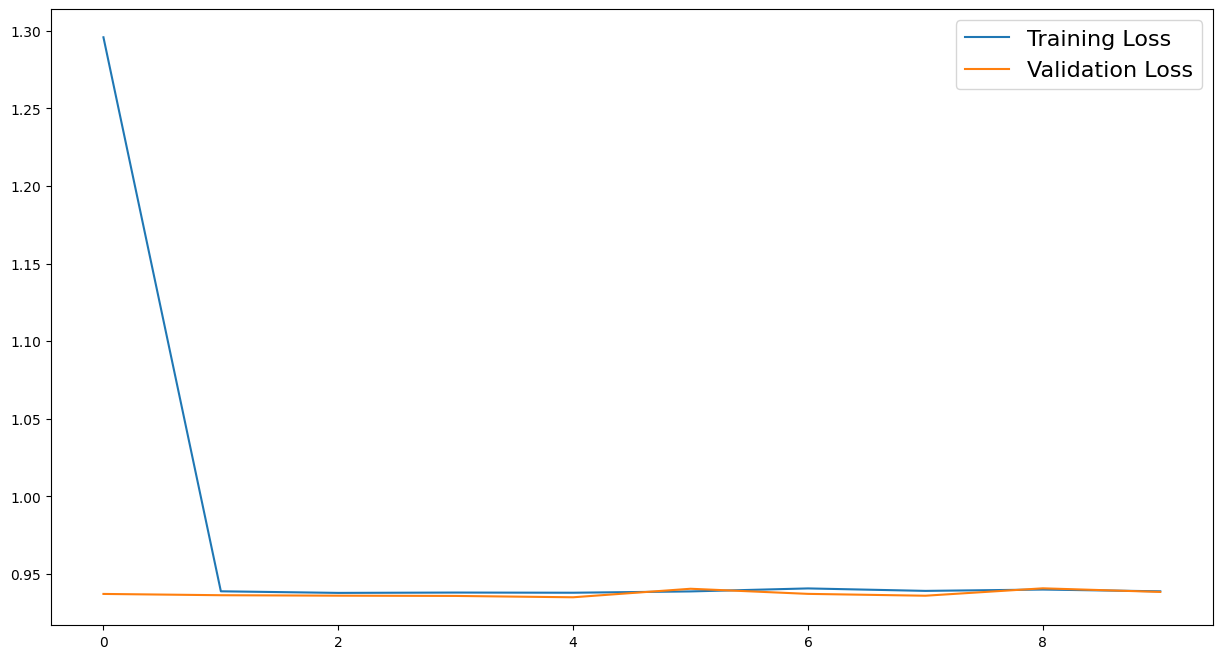

In [48]:
# Learning Curves
plt.figure(figsize=(15,8))

epochs_run = len(history.history['loss'])
plt.plot(np.arange(0, epochs_run), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, epochs_run), history.history['val_loss'], label='Validation Loss')


plt.legend(fontsize=16)
plt.show()

In [49]:
y_pred = model_10_birnn.predict(X_test)
#y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)

923/923 [==============================] - 31s 32ms/step


In [50]:
from sklearn.metrics import mean_squared_error
print(f"Deep RNN with 10 steps forward MSE : {mean_squared_error(np.ravel(y_pred), np.ravel(y_test)):.4f}")

Deep RNN with 10 steps forward MSE : 5.7126


In [52]:
model_10_birnn.evaluate(X_test, y_test)

923/923 [==============================] - 35s 38ms/step - loss: 0.9358


0.9358246922492981

In [ ]:
# comparing the MSE and the accuracy of the single RNN, deep RNN and bidirectionnal RNN; we notice that the Deep RNN is the most efficient architecture
#Followed by the Deep RNN architecture and last the Simple RNN

# LSTM.

In [29]:
reset_seeds()
tf.keras.backend.clear_session()

model_lstm = tf.keras.models.Sequential([tf.keras.Input(shape=(200,)),
                                         tf.keras.layers.Embedding(5000, 20, mask_zero=True),
                                         tf.keras.layers.LSTM(32, return_sequences=True),
                                         tf.keras.layers.LSTM(32),
                                         tf.keras.layers.Dense(1, activation='sigmoid')])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           100000    
                                                                 
 lstm (LSTM)                 (None, 200, 32)           6784      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 115,137
Trainable params: 115,137
Non-trainable params: 0
_________________________________________________________________


In [62]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model_lstm.fit(X_train[...,np.newaxis], y_train,
                         epochs=5,
                         batch_size=512,
                         validation_data=(X_val[...,np.newaxis], y_val),
                         callbacks=[early])

Epoch 1/5
173/173 [==============================] - 153s 869ms/step - loss: -41.1000 - accuracy: 0.0302 - val_loss: -42.0695 - val_accuracy: 0.0302
Epoch 2/5
173/173 [==============================] - 169s 980ms/step - loss: -43.0082 - accuracy: 0.0302 - val_loss: -43.9715 - val_accuracy: 0.0302
Epoch 3/5
173/173 [==============================] - 204s 1s/step - loss: -44.9051 - accuracy: 0.0302 - val_loss: -45.8634 - val_accuracy: 0.0302
Epoch 4/5
173/173 [==============================] - 172s 995ms/step - loss: -46.7928 - accuracy: 0.0302 - val_loss: -47.7475 - val_accuracy: 0.0302
Epoch 5/5
173/173 [==============================] - 192s 1s/step - loss: -48.6734 - accuracy: 0.0302 - val_loss: -49.6250 - val_accuracy: 0.0302


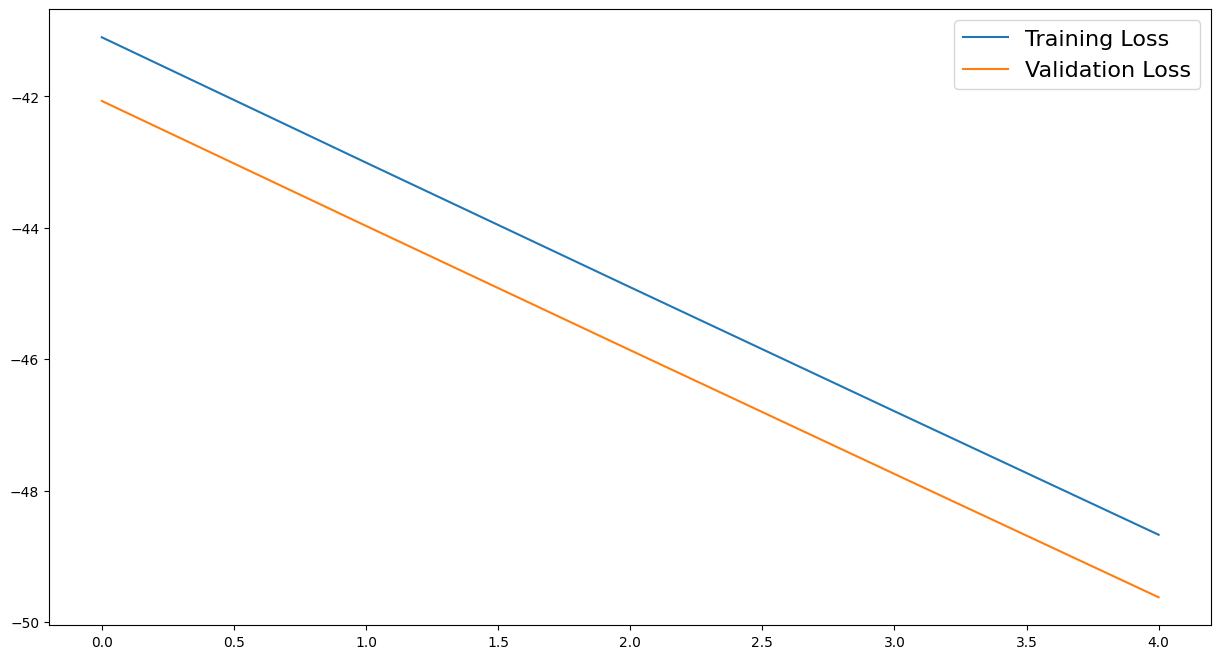

In [63]:
# Learning Curves
plt.figure(figsize=(15,8))

epochs_run = len(history.history['loss'])
plt.plot(np.arange(0, epochs_run), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, epochs_run), history.history['val_loss'], label='Validation Loss')


plt.legend(fontsize=16)
plt.show()

In [55]:
y_pred = model_10_birnn.predict(X_test)
#y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)

#model_lstm.evaluate(X_test, y_test)


923/923 [==============================] - 33s 36ms/step


In [ ]:
#LSTM is really slow

# GRU.

In [56]:
reset_seeds()
tf.keras.backend.clear_session()

model_gru = tf.keras.models.Sequential([tf.keras.Input(shape=(200,)),
                                        tf.keras.layers.Embedding(5000, 20, mask_zero=True),
                                        tf.keras.layers.GRU(32, return_sequences=True),
                                        tf.keras.layers.GRU(32),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])

model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           100000    
                                                                 
 gru (GRU)                   (None, 200, 32)           5184      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 111,553
Trainable params: 111,553
Non-trainable params: 0
_________________________________________________________________


In [59]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model_gru.fit(X_train[...,np.newaxis], y_train,
                        epochs=5,
                        batch_size=512,
                        validation_data=(X_val[...,np.newaxis], y_val),
                        callbacks=[early])

Epoch 1/5
173/173 [==============================] - 166s 957ms/step - loss: -25.5524 - accuracy: 0.0302 - val_loss: -26.7952 - val_accuracy: 0.0302
Epoch 2/5
173/173 [==============================] - 127s 735ms/step - loss: -27.9061 - accuracy: 0.0302 - val_loss: -29.0091 - val_accuracy: 0.0302
Epoch 3/5
173/173 [==============================] - 122s 701ms/step - loss: -30.0563 - accuracy: 0.0302 - val_loss: -31.1085 - val_accuracy: 0.0302
Epoch 4/5
173/173 [==============================] - 122s 704ms/step - loss: -32.1166 - accuracy: 0.0302 - val_loss: -33.1339 - val_accuracy: 0.0302
Epoch 5/5
173/173 [==============================] - 120s 694ms/step - loss: -34.1162 - accuracy: 0.0302 - val_loss: -35.1113 - val_accuracy: 0.0302


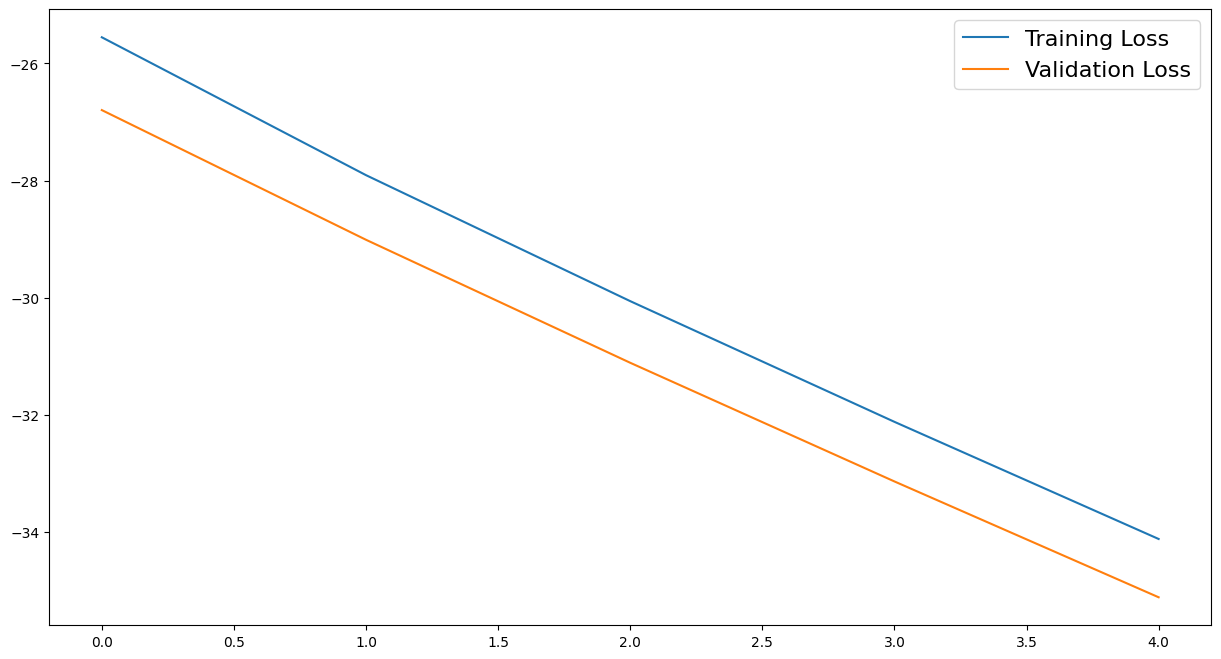

In [60]:
# Learning Curves
plt.figure(figsize=(15,8))

epochs_run = len(history.history['loss'])
plt.plot(np.arange(0, epochs_run), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, epochs_run), history.history['val_loss'], label='Validation Loss')


plt.legend(fontsize=16)
plt.show()

In [ ]:
# The GRU and the LSTM are quite the same there is no difference among them but 
# Comparing the speed; the GRU is faster than the LSTM